# Bonus1: Parallel Algorithms

### Name: [Rajat verma]


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.12671496 -0.05509579 -0.03460194 -0.01180321 -0.14166316 -0.03991987
  -0.19431636 -0.00387052]]
test std = 
[[0.90459288 0.94279268 1.15341101 1.11761809 0.86904028 1.05231813
  0.65489475 1.02309341]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


## Worker Node

In [5]:
class Worker:
    def __init__(self, x, y, q, alpha, lam, beta):
        self.x = x #s-by-d local feature matrix
        self.y = y #s-by-1 local label matrix
        self.s = x.shape[0] #number of local samples
        self.d = x.shape[1] #number of features
        self.w = numpy.zeros((self.d, 1)) #d-by-1 model parameter vecotr
        self.q = q #Number of times local gradient to be performed
        self.v = numpy.zeros((self.d, 1)) #d-by1 momentum
        self.alpha = alpha #Local learning rate
        self.initial_w = numpy.zeros((self.d, 1)) #To store the w broadcasted by server for finding direction at the end
        self.lam = lam #regularization parameter
        self.beta = beta #momentum parameter 
    #Set the model parameters to the latest
    def set_param(self, w):
        self.w = w
        self.initial_w = w
    
    #compute the local loss
    def loss(self):
        yx = numpy.multiply(self.y, self.x) #s-by-d matrix
        yxw = numpy.dot(yx, self.w) #s-by-1 matrix
        vec1 = numpy.exp(-yxw) #s-by-1 matrix
        vec2 = numpy.log(1 + vec1) #s-by-1 matrix
        reg = self.lam / 2*numpy.sum(self.w * self.w)
        losses = numpy.sum(vec2)/self.s + reg #loss function
        return losses
    
    #Compute the local gradient 
    def gradient(self):
        yx = numpy.multiply(self.y, self.x) # s-by-d
        yxw = numpy.dot(yx, self.w) # s-by-1
        vec1 = numpy.exp(yxw) # s-by-1
        vec2 = numpy.divide(yx, 1+vec1) # s-by-d
        reg = self.lam / 2*numpy.sum(self.w * self.w)
        g = -numpy.mean(vec2, axis=0).reshape(self.d, 1)+reg # d-by-1
        return g

    
    #Compute q gradient 
    def gradient_descent_local(self):
        for i in range(self.q):
            gradient = self.gradient()
            self.v = self.beta*self.v + gradient
            self.w -= self.alpha * self.v
            losses = self.loss()
            print("local objective function value ", losses)
        return self.w
    
    #Compute Stochastic gradient descent
    def sgd(self, i, x_rand, y_rand):
        import numpy as np
        xi = x_rand[i,:]
        yi = float(y_rand[i,:])
        d = xi.shape[0]
        yx = yi * xi
        yxw = float(np.dot(yx, self.w))
        loss = np.log(1 + np.exp(-yxw))
        reg = lam / 2 * np.sum(self.w * self.w)
        obj = loss + reg
        gradient = -yx.T / (1 + np.exp(yxw))
        gradient = gradient + lam * self.w
        return gradient, obj
    
    #Compute q stochastic gradients 
    def stochgradient_descent_local(self):
        import numpy as np
        for i in range(self.q):
            rand_indices = np.random.permutation(self.s)
            x_rand = self.x[rand_indices,:]
            y_rand = self.y[rand_indices,:]
            stcobj = 0
            for i in range(self.s):
                gradient, obj = self.sgd(i, x_rand, y_rand)
                self.w -= self.alpha * gradient
                stcobj+=obj
            self.alpha *= 0.9 # decrease step size
            stcobj /= self.s
            print("local objective function value ", stcobj)
            
        return self.w
    
    #Find direction to be sent back to server
    def find_direction(self):
        pk = self.initial_w - self.gradient_descent_local()
        return pk
    
    #Find direction to be sent back to server stochastic gradient 
    def find_stochdirection(self):
        pk = self.initial_w - self.stochgradient_descent_local()
        return pk
        

In [6]:
class Server:
    def __init__(self, m, n, d, alpha, lam):
        self.m = m #number of worker nodes
        self.n = n #number of training samples
        self.d = d #number of features
        self.w = numpy.zeros((d, 1)) #d-by-1 model parameter vector
        self.pk = numpy.zeros((d, 1)) #directions recieved from different workers
        self.alpha = alpha #Server Learning rate
        self.lam = lam #Server reg parameter
        self.loss = 0 #loss function value
        self.communication = 0
#         self.obj = 0 #objective function value
#         self.g = numpy.zeros((d, 1)) #d-by-1 gradient
#         self.v = numpy.zeros((d, 1)) #d-by1 momentum

    def broadcast(self):
        self.communication+=1
        return self.w
    
    def aggregate(self, pk, losses):
        #self.g = numpy.zeros((self.d, 1))
        #self.loss = 0
        #for k in range(self.m):
            #self.pk += pk[k]
            #self.loss += losses[k]
        #self.pk = self.pk/self.m
        self.pk = numpy.mean(numpy.array(pk), axis=0)
        self.loss = sum(losses)
        self.communication+=1
    
    def update(self):
        self.w = self.w - self.alpha*self.pk
        self.alpha *= 0.9 # decrease step size
            
    #Compute the objective function (sum of loss and regularization)
    def objective(self):
        reg = self.lam/2 * numpy.sum(self.w*self.w)
        self.obj = self.loss/self.m + reg
        return self.obj

## Initialization for q=1

In [7]:
import math

#Create a server and m worker nodes
def create_server_workers(m, x, y, q, alpha, lam, beta):
    n, d = x.shape
    s = math.floor(n / m)
    server = Server(m, n, d, alpha, lam)
    workers = []
    
    for i in range(m):
        indices = list(range(i*s, (i+1)*s))
        #print(x.shape)
        worker = Worker(x[indices, :], y[indices, :], q, alpha, lam, beta)
        workers.append(worker)
        
    return server, workers

m = 4 #number of worker nodes
q = 1
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [8]:
max_epoch = 50 #number of epochs
communication1 = 0 #number of communication
objective_val_1 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    communication1 = communication1+1
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    pk_1 = []
    losses_1 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_direction()
        pk_1.append(g)
        l = workers[i].loss()
        losses_1.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(pk_1, losses_1)
    communication1= communication1+1
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    objective_val_1.append(obj)
    print('Objective function value = '+str(obj))
print("Number of communications", server.communication)

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6920969280592031
Worker 2
local objective function value  0.6907877387647423
Worker 3
local objective function value  0.6885869070064792
Worker 4
local objective function value  0.6883327087287867
Objective function value = 0.6899510807111966
----------------------------------epoch1-------------------------------
Worker 1
local objective function value  0.68679751166017
Worker 2
local objective function value  0.6838183045567408
Worker 3
local objective function value  0.6788772961039453
Worker 4
local objective function value  0.6794976306670518
Objective function value = 0.6822477691500055
----------------------------------epoch2-------------------------------
Worker 1
local objective function value  0.6780479027660066
Worker 2
local objective function value  0.6731402751330209
Worker 3
local objective function value  0.6651500738582904
Worker 4
local objective function 

local objective function value  0.4766530662477995
Objective function value = 0.48103259036017826
----------------------------------epoch45-------------------------------
Worker 1
local objective function value  0.5270411795897635
Worker 2
local objective function value  0.4770155102902247
Worker 3
local objective function value  0.442532266589056
Worker 4
local objective function value  0.47665744714774855
Objective function value = 0.48093779728677527
----------------------------------epoch46-------------------------------
Worker 1
local objective function value  0.527026558982464
Worker 2
local objective function value  0.47678499851427864
Worker 3
local objective function value  0.4424323785683749
Worker 4
local objective function value  0.4766777589197484
Objective function value = 0.4808574317233391
----------------------------------epoch47-------------------------------
Worker 1
local objective function value  0.5270214963546377
Worker 2
local objective function value  0.4765681

## Initialization for q= 8

In [9]:
m = 4 #number of worker nodes
q = 8
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [10]:
max_epoch = 50 #number of epochs
objective_val_8 = []
communication8 = 0
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    communication8 = communication8+1
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    pk_8 = []
    losses_8 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_direction()
        pk_8.append(g)
        l = workers[i].loss()
        losses_8.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(pk_8, losses_8)
    communication8 = communication8+1
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    objective_val_8.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6920969280592031
local objective function value  0.6901164122337246
local objective function value  0.6873256722380378
local objective function value  0.6838420434200535
local objective function value  0.6797780338132372
local objective function value  0.6752397366143671
local objective function value  0.6703256972941354
local objective function value  0.6651261654921925
Worker 2
local objective function value  0.6643077750035549
local objective function value  0.6622351533639876
local objective function value  0.6593140556341509
local objective function value  0.655666660890157
local objective function value  0.6514099462439925
local objective function value  0.646654042563158
local objective function value  0.6415010704454354
local objective function value  0.6360443854138886
Worker 3
local objective function value  0.6255921160843325
local objective function value  0.62

local objective function value  0.47799191141504666
local objective function value  0.4778125542673089
local objective function value  0.4776350758052366
local objective function value  0.4774596558487119
local objective function value  0.4772864472187544
local objective function value  0.4771155784423347
local objective function value  0.4769471562393867
Objective function value = 0.477216745296363
----------------------------------epoch8-------------------------------
Worker 1
local objective function value  0.5298094646276333
local objective function value  0.5284526661188516
local objective function value  0.5271247376631363
local objective function value  0.5258303805020905
local objective function value  0.5245734205878548
local objective function value  0.5233568853749206
local objective function value  0.5221830790804779
local objective function value  0.5210536557128458
Worker 2
local objective function value  0.48213843680689444
local objective function value  0.4800844767613

local objective function value  0.4796074881578906
local objective function value  0.47939467263775964
local objective function value  0.4791839250241792
local objective function value  0.4789755266930206
local objective function value  0.47876971665658635
local objective function value  0.47856669589003153
local objective function value  0.4783666313077882
local objective function value  0.4781696594074997
Objective function value = 0.47688691287649004
----------------------------------epoch17-------------------------------
Worker 1
local objective function value  0.5287778783328216
local objective function value  0.527409379029102
local objective function value  0.5260715310105615
local objective function value  0.5247691105757287
local objective function value  0.5235059932023507
local objective function value  0.5222852318676499
local objective function value  0.5211091340125753
local objective function value  0.5199793364104042
Worker 2
local objective function value  0.4815905286

local objective function value  0.4787809273363162
local objective function value  0.47857763984861995
local objective function value  0.47837731416549384
local objective function value  0.4781800873310063
Objective function value = 0.4768841514820003
----------------------------------epoch26-------------------------------
Worker 1
local objective function value  0.5287046221359587
local objective function value  0.5273380878534364
local objective function value  0.5260021118102787
local objective function value  0.5247014821141487
local objective function value  0.5234400845525528
local objective function value  0.5222209810196295
local objective function value  0.5210464865903464
local objective function value  0.5199182445005902
Worker 2
local objective function value  0.4815866144173021
local objective function value  0.4795362553056375
local objective function value  0.47753993614769163
local objective function value  0.47560556663639797
local objective function value  0.473739321

local objective function value  0.47837778751801835
local objective function value  0.4781805518774629
Objective function value = 0.476883990029292
----------------------------------epoch35-------------------------------
Worker 1
local objective function value  0.5287023416885182
local objective function value  0.527335872851001
local objective function value  0.5259999599103862
local objective function value  0.5246993910669083
local objective function value  0.5234380521920469
local objective function value  0.5222190052567867
local objective function value  0.5210445654070989
local objective function value  0.5199163759451462
Worker 2
local objective function value  0.4815866545449089
local objective function value  0.4795362581688394
local objective function value  0.4775399029138877
local objective function value  0.4756054986506528
local objective function value  0.47373922047183276
local objective function value  0.471945686326946
local objective function value  0.47022813083274

local objective function value  0.5273357962406885
local objective function value  0.5259998851338631
local objective function value  0.5246993180812191
local objective function value  0.5234379809552075
local objective function value  0.5222189357275079
local objective function value  0.521044497544557
local objective function value  0.5199163097088033
Worker 2
local objective function value  0.4815866135916073
local objective function value  0.4795362162645376
local objective function value  0.47753986019216504
local objective function value  0.4756054552421245
local objective function value  0.47373917650267516
local objective function value  0.47194564191778143
local objective function value  0.47022808609783967
local objective function value  0.46858852778852333
Worker 3
local objective function value  0.44347434340449554
local objective function value  0.4429934700982283
local objective function value  0.4425207381230449
local objective function value  0.4420573141851219
local ob

## plot curve

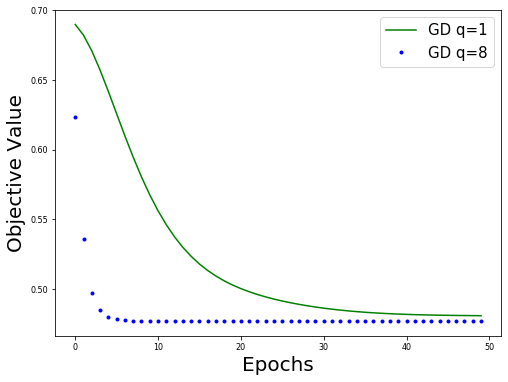

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 6))

epochs_gd_1 = epochs_gd_8 = range(len(objective_val_1))
 

line0, = plt.plot(epochs_gd_1, objective_val_1, '-g', LineWidth=1.5)
line1, = plt.plot(epochs_gd_8, objective_val_8, '.b', LineWidth=1.5)

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1], ['GD q=1','GD q=8'], fontsize=15)
plt.show()

## Q=1 for sgd

In [12]:

m = 4 #number of worker nodes
q = 1
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [13]:
max_epoch = 50 #number of epochs
sgd_objective_val_1 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    sgd_pk_1 = []
    sgd_losses_1 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_stochdirection()
        sgd_pk_1.append(g)
        l = workers[i].loss()
        sgd_losses_1.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(sgd_pk_1, sgd_losses_1)
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    sgd_objective_val_1.append(obj)
    print('Objective function value = '+str(obj))
    

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6426885172559021
Worker 2
local objective function value  0.5660803430572654
Worker 3
local objective function value  0.5032501387666044
Worker 4
local objective function value  0.5146784562527829
Objective function value = 0.5257621759003811
----------------------------------epoch1-------------------------------
Worker 1
local objective function value  0.5383849624087864
Worker 2
local objective function value  0.502397139101584
Worker 3
local objective function value  0.4618199386154568
Worker 4
local objective function value  0.4916912077582225
Objective function value = 0.48522733813417535
----------------------------------epoch2-------------------------------
Worker 1
local objective function value  0.5299571060757454
Worker 2
local objective function value  0.49056744629827104
Worker 3
local objective function value  0.45326266037071755
Worker 4
local objective funct

local objective function value  0.5281598830656039
Worker 2
local objective function value  0.4747280050075756
Worker 3
local objective function value  0.4418836494202917
Worker 4
local objective function value  0.4791567526301986
Objective function value = 0.4800342423121007
----------------------------------epoch26-------------------------------
Worker 1
local objective function value  0.5281208776967438
Worker 2
local objective function value  0.47466431813565535
Worker 3
local objective function value  0.44182049209066704
Worker 4
local objective function value  0.4791125365052826
Objective function value = 0.48008950222388924
----------------------------------epoch27-------------------------------
Worker 1
local objective function value  0.5280701225842683
Worker 2
local objective function value  0.4746083288785017
Worker 3
local objective function value  0.4417687761957911
Worker 4
local objective function value  0.4790744403220114
Objective function value = 0.4801344995493513
--

## q= 8 SGD

In [14]:
m = 4 #number of worker nodes
q = 8
lam = 1E-4 #regularization parameter
alpha = 0.01 #learning rate
beta = 0.9 #momentum parameter 
server, workers = create_server_workers(m, x_train, y_train, q, alpha, lam, beta)

In [15]:
max_epoch = 50 #number of epochs
sgd_objective_val_8 = []
for t in range(max_epoch):
    print("----------------------------------epoch"+str(t)+"-------------------------------")
    #step 1: broadcast
    w = server.broadcast()
    for i in range(m):
        workers[i].set_param(w)
        
    #step 2: workers' local computations
    sgd_pk_8 = []
    sgd_losses_8 = []
    for i in range(m):
        print("Worker "+str(i+1))
        g = workers[i].find_stochdirection()
        sgd_pk_8.append(g)
        l = workers[i].loss()
        sgd_losses_8.append(l)
        
    #step 3: aggregate the workers' outputs
    server.aggregate(sgd_pk_8, sgd_losses_8)
    
    #step 4: server update the model parameters
    server.update() #compute gradient
    obj = server.objective() #compute objective function
    sgd_objective_val_8.append(obj)
    print('Objective function value = '+str(obj))

----------------------------------epoch0-------------------------------
Worker 1
local objective function value  0.6440939393686648
local objective function value  0.5800778461869702
local objective function value  0.5521105377357457
local objective function value  0.5375445212355644
local objective function value  0.5284140581673973
local objective function value  0.5226518214562839
local objective function value  0.5184471140997748
local objective function value  0.5152573895924635
Worker 2
local objective function value  0.5270626442661687
local objective function value  0.49253129543926566
local objective function value  0.476829491054182
local objective function value  0.4683876014237073
local objective function value  0.46285003600004915
local objective function value  0.4587991350528373
local objective function value  0.4559601775603405
local objective function value  0.45375020246118797
Worker 3
local objective function value  0.47034973423399606
local objective function value 

local objective function value  0.47717059174080945
local objective function value  0.4770932853560524
local objective function value  0.47702430972555304
local objective function value  0.47696226599483194
local objective function value  0.4769068792047514
Objective function value = 0.47943905719778335
----------------------------------epoch5-------------------------------
Worker 1
local objective function value  0.5328752405632605
local objective function value  0.5325006216197053
local objective function value  0.5321670130224202
local objective function value  0.5318697088259827
local objective function value  0.5316048775606411
local objective function value  0.5313684335105093
local objective function value  0.5311570763669684
local objective function value  0.5309681834315544
Worker 2
local objective function value  0.47435663347064727
local objective function value  0.4739474778485578
local objective function value  0.47358428354441884
local objective function value  0.47326183

local objective function value  0.4769806598808759
local objective function value  0.4769790953028571
local objective function value  0.47697768738005913
local objective function value  0.4769764203414987
local objective function value  0.4769752801928376
local objective function value  0.4769742541460091
local objective function value  0.4769733307585227
local objective function value  0.47697249977082334
Objective function value = 0.4808152886006855
----------------------------------epoch10-------------------------------
Worker 1
local objective function value  0.5322550584895982
local objective function value  0.5322495566351924
local objective function value  0.5322446057557195
local objective function value  0.5322401506195726
local objective function value  0.5322361414788099
local objective function value  0.5322325337232247
local objective function value  0.5322292870966643
local objective function value  0.532226365404804
Worker 2
local objective function value  0.472893712916

local objective function value  0.4728717989708263
local objective function value  0.47287169328870615
Worker 3
local objective function value  0.4407122194641112
local objective function value  0.4407121688876313
local objective function value  0.44071212336895965
local objective function value  0.4407120824022911
local objective function value  0.4407120455324004
local objective function value  0.44071201234959306
local objective function value  0.4407119824851443
local objective function value  0.4407119556071849
Worker 4
local objective function value  0.47697360233273767
local objective function value  0.47697357921527106
local objective function value  0.47697355840958355
local objective function value  0.47697353968450174
local objective function value  0.4769735228319516
local objective function value  0.4769735076646797
local objective function value  0.47697349401414996
local objective function value  0.4769734817286831
Objective function value = 0.4808358184447089
----------

local objective function value  0.47287199583198597
local objective function value  0.47287199289263776
local objective function value  0.4728719902472238
local objective function value  0.4728719878663519
local objective function value  0.47287198572356726
local objective function value  0.47287198379506135
local objective function value  0.47287198205940595
local objective function value  0.47287198049731616
Worker 3
local objective function value  0.4407120100930741
local objective function value  0.4407120093455205
local objective function value  0.44071200867272226
local objective function value  0.4407120080672037
local objective function value  0.44071200752223677
local objective function value  0.44071200703176705
local objective function value  0.44071200659034415
local objective function value  0.4407120061930634
Worker 4
local objective function value  0.47697349802893685
local objective function value  0.476973497687242
local objective function value  0.47697349737971706
lo

local objective function value  0.4769734964774906
local objective function value  0.47697349646979265
local objective function value  0.4769734964628647
local objective function value  0.4769734964566295
Objective function value = 0.4808361263233185
----------------------------------epoch24-------------------------------
Worker 1
local objective function value  0.5322454486553223
local objective function value  0.5322454486140533
local objective function value  0.532245448576911
local objective function value  0.5322454485434832
local objective function value  0.5322454485133978
local objective function value  0.532245448486321
local objective function value  0.5322454484619518
local objective function value  0.5322454484400199
Worker 2
local objective function value  0.4728719849691287
local objective function value  0.472871984925683
local objective function value  0.47287198488658133
local objective function value  0.47287198485138954
local objective function value  0.4728719848197

local objective function value  0.4407120069535765
local objective function value  0.44071200695319696
local objective function value  0.44071200695285573
local objective function value  0.4407120069525482
local objective function value  0.44071200695227153
local objective function value  0.44071200695202284
local objective function value  0.4407120069517987
local objective function value  0.4407120069515972
Worker 4
local objective function value  0.4769734964649023
local objective function value  0.4769734964647293
local objective function value  0.476973496464573
local objective function value  0.4769734964644326
local objective function value  0.4769734964643059
local objective function value  0.47697349646419224
local objective function value  0.47697349646409026
local objective function value  0.47697349646399767
Objective function value = 0.48083612647734447
----------------------------------epoch29-------------------------------
Worker 1
local objective function value  0.532245

local objective function value  0.47287198480621806
local objective function value  0.47287198480619813
local objective function value  0.47287198480618053
local objective function value  0.4728719848061641
local objective function value  0.4728719848061497
local objective function value  0.4728719848061373
local objective function value  0.4728719848061253
Worker 3
local objective function value  0.4407120069520062
local objective function value  0.44071200695200047
local objective function value  0.44071200695199486
local objective function value  0.44071200695199064
local objective function value  0.44071200695198665
local objective function value  0.44071200695198326
local objective function value  0.44071200695197976
local objective function value  0.44071200695197676
Worker 4
local objective function value  0.47697349646412013
local objective function value  0.4769734964641172
local objective function value  0.4769734964641155
local objective function value  0.47697349646411313
l

local objective function value  0.5322454485831921
local objective function value  0.5322454485831913
local objective function value  0.5322454485831913
local objective function value  0.5322454485831912
local objective function value  0.5322454485831909
local objective function value  0.5322454485831908
local objective function value  0.5322454485831905
local objective function value  0.5322454485831903
Worker 2
local objective function value  0.47287198480615966
local objective function value  0.47287198480615905
local objective function value  0.472871984806159
local objective function value  0.47287198480615916
local objective function value  0.47287198480615833
local objective function value  0.4728719848061583
local objective function value  0.472871984806158
local objective function value  0.4728719848061577
Worker 3
local objective function value  0.44071200695198154
local objective function value  0.44071200695198137
local objective function value  0.4407120069519813
local obj

local objective function value  0.4769734964641117
local objective function value  0.4769734964641117
local objective function value  0.4769734964641117
local objective function value  0.47697349646411136
Objective function value = 0.4808361264796548
----------------------------------epoch43-------------------------------
Worker 1
local objective function value  0.5322454485831907
local objective function value  0.532245448583191
local objective function value  0.5322454485831909
local objective function value  0.5322454485831907
local objective function value  0.5322454485831909
local objective function value  0.5322454485831912
local objective function value  0.5322454485831906
local objective function value  0.5322454485831909
Worker 2
local objective function value  0.47287198480615783
local objective function value  0.47287198480615755
local objective function value  0.472871984806158
local objective function value  0.4728719848061579
local objective function value  0.472871984806

local objective function value  0.4407120069519813
Worker 4
local objective function value  0.4769734964641118
local objective function value  0.4769734964641116
local objective function value  0.4769734964641116
local objective function value  0.47697349646411136
local objective function value  0.4769734964641115
local objective function value  0.4769734964641114
local objective function value  0.4769734964641115
local objective function value  0.47697349646411136
Objective function value = 0.4808361264796548
----------------------------------epoch48-------------------------------
Worker 1
local objective function value  0.5322454485831909
local objective function value  0.5322454485831913
local objective function value  0.5322454485831911
local objective function value  0.5322454485831909
local objective function value  0.5322454485831907
local objective function value  0.5322454485831905
local objective function value  0.5322454485831905
local objective function value  0.53224544858

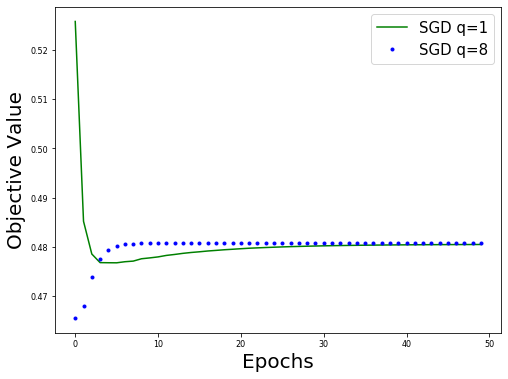

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 6))

epochs_sgd_1 = epochs_sgd_8 = range(len(sgd_objective_val_1))

line0, = plt.plot(epochs_sgd_1, sgd_objective_val_1, '-g')
line1, = plt.plot(epochs_sgd_8, sgd_objective_val_8, '.b')

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1], ['SGD q=1','SGD q=8'], fontsize=15)
plt.show()

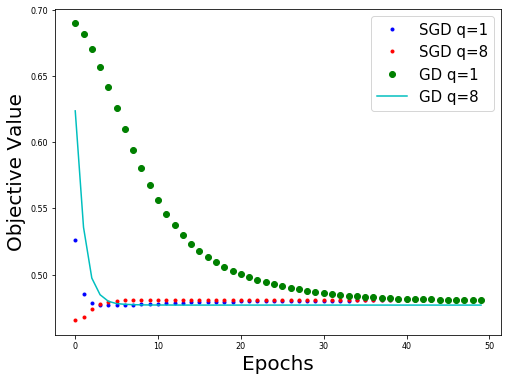

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 6))

epochs_sgd_1 =epochs_sgd_8= range(len(sgd_objective_val_1))

line0, = plt.plot(epochs_sgd_1, sgd_objective_val_1, '.b')
line1, = plt.plot(epochs_sgd_8, sgd_objective_val_8, '.r')
line2, = plt.plot(epochs_gd_1, objective_val_1, 'og')
line3, = plt.plot(epochs_gd_8, objective_val_8, '-c')

plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=8)
plt.yticks(FontSize=8)
plt.legend([line0, line1, line2, line3], ['SGD q=1','SGD q=8', 'GD q=1', 'GD q=8'], fontsize=15)
plt.show()